# Proyecto 03 - Series de Tiempo

## Dataset: Flujo Vehicular por Unidades de Peaje AUSA

**Recuerda descargar el dataset de [aquí](https://data.buenosaires.gob.ar/dataset/flujo-vehicular-por-unidades-peaje-ausa). Deberás descargar -  al menos para comenzar - los años 2017, 2018 y 2019.**

En este notebook te dejamos unas celdas para que puedas comenzar a trabajar con este dataset para los años 2017, 2018 y 2019. Si deseas utilizar otros años, ten en cuenta que deberás hacer el preprocesamiento correspondiente, ya que la estructura de los datos puede variar.

**Importante:** Para el proyecto, debes comenzar con los datos de la autopista Illia, pago en Efectivo.

### Exploración de datos

Dedícale un buen tiempo a hacer un Análisis Exploratorio de Datos. Elige preguntas que creas que puedas responder con este dataset. Por ejemplo, ¿Cuáles son los días y horarios de mayor tráfico? También, estudia autocorrelaciones, resampleos, etc.

#### Componentes de la serie

1. Calcula las componentes estacionales y tendencia de la serie. Interpreta los resultados, si es necesario con información auxiliar (por fuera del dataset) o elementos del dataset que no estés utilizando (por ejemplo, si la tendencia es negativa, ¿puede ser porque se migre a otras formas de pago?).
1. ¿La serie posee valores atípicos? Si es así, interpreta, si es necesario con información auxiliar. **Pista**: primer semestre 2019.

### Predicción a Futuro

Debes implementar un modelo que prediga el tráfico en la autopista Illia para el último trimestre del 2019. 

1. Haz todas las transformaciones de datos que consideres necesarias. Justifica.
1. Evalúa de forma apropiada tus resultados. Justifica la métrica elegida.
1. Elige un modelo benchmark y compara tus resultados con este modelo.
1. Optimiza los hiperparámetros de tu modelo. 
1. Intenta responder la pregunta: ¿Qué información está usando el modelo para predecir?
1. Utiliza el modelo creado para predecir el tráfico en el año 2020. ¿Cómo funciona?
1. Si lo deseas, puedes agregar información de años anteriores a 2017. ¿Mejoran los resultados?

### Para pensar, investigar y, opcionalmente, implementar
1. ¿Cómo incorporarías la información sobre tipo de vehículo, forma de pago, sentido, día de la semana, etc.? En lo que respecta a las predicciones, ¿mejoran o empeoran?
1. ¿Qué ocurre si comparas las series de tiempo entre distintas estaciones de peajes?¿Tienen el mismo comportamiento o hay alguna que sea distinta a las otras? Si es así, ¿hay información auxiliar que te ayude a explicar lo que encuentras?
1. ¿Hay algo que te gustaría investigar o probar?

### **¡Tómate tiempo para investigar y leer mucho!**

### 1. Preparación del Dataset

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
from fbprophet import Prophet
from pmdarima.arima import auto_arima
from statsmodels.tsa.seasonal import seasonal_decompose
from pandas_profiling import ProfileReport
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error
import seaborn as sns
sns.set() 

Importing plotly failed. Interactive plots will not work.


In [2]:
data_2020 = pd.read_csv(r'C:\Users\guido\Downloads\flujo-vehicular-2020.csv', sep =',')
data_2019 = pd.read_csv(r'C:\Users\guido\Downloads\flujo-vehicular-2019.csv', sep =',')
data_2018 = pd.read_csv(r'C:\Users\guido\Downloads\flujo-vehicular-2018.csv', sep =',')
data_2017 = pd.read_csv(r'C:\Users\guido\Downloads\flujo-vehicular-2017.csv', sep =',')

In [3]:
data_2019.info()
data_2019.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 812153 entries, 0 to 812152
Data columns (total 10 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   periodo         812153 non-null  int64 
 1   fecha           812153 non-null  object
 2   hora_inicio     812153 non-null  int64 
 3   hora_fin        812153 non-null  int64 
 4   dia             812153 non-null  object
 5   estacion        812153 non-null  object
 6   sentido         812153 non-null  object
 7   tipo_vehiculo   812153 non-null  object
 8   forma_pago      812153 non-null  object
 9   cantidad_pasos  812153 non-null  int64 
dtypes: int64(4), object(6)
memory usage: 62.0+ MB


periodo       fecha  hora_inicio  hora_fin     dia    estacion    sentido  \
0     2019  2019-01-01            0         1  Martes     Alberti     Centro   
1     2019  2019-01-01            0         1  Martes     Alberti     Centro   
2     2019  2019-01-01            0         1  Martes     Alberti  Provincia   
3     2019  2019-01-01            0         1  Martes     Alberti  Provincia   
4     2019  2019-01-01            0         1  Martes  Avellaneda     Centro   

  tipo_vehiculo  forma_pago  cantidad_pasos  
0       Liviano  NO COBRADO              22  
1       Liviano    TELEPASE               6  
2       Liviano  NO COBRADO              53  
3       Liviano    TELEPASE              18  
4       Liviano    EFECTIVO              16

In [4]:
data_2018.info()
data_2018.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1375908 entries, 0 to 1375907
Data columns (total 10 columns):
 #   Column          Non-Null Count    Dtype 
---  ------          --------------    ----- 
 0   periodo         1375908 non-null  int64 
 1   fecha           1375908 non-null  object
 2   hora_inicio     1375908 non-null  int64 
 3   hora_fin        1375908 non-null  int64 
 4   dia             1375908 non-null  object
 5   estacion        1375908 non-null  object
 6   sentido         1375908 non-null  object
 7   tipo_vehiculo   1375908 non-null  object
 8   forma_pago      1375908 non-null  object
 9   cantidad_pasos  1375908 non-null  int64 
dtypes: int64(4), object(6)
memory usage: 105.0+ MB


periodo       fecha  hora_inicio  hora_fin    dia estacion sentido  \
0     2018  2018-01-01            0         1  Lunes  Alberdi  Centro   
1     2018  2018-01-01            0         1  Lunes  Alberdi  Centro   
2     2018  2018-01-01            1         2  Lunes  Alberdi  Centro   
3     2018  2018-01-01            1         2  Lunes  Alberdi  Centro   
4     2018  2018-01-01            2         3  Lunes  Alberdi  Centro   

  tipo_vehiculo  forma_pago  cantidad_pasos  
0       Liviano  NO COBRADO              29  
1       Liviano    TELEPASE               9  
2       Liviano  NO COBRADO              73  
3       Liviano    TELEPASE              39  
4       Liviano  NO COBRADO             115

In [5]:
data_2017.info()
data_2017.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1372645 entries, 0 to 1372644
Data columns (total 10 columns):
 #   Column          Non-Null Count    Dtype 
---  ------          --------------    ----- 
 0   periodo         1372645 non-null  int64 
 1   fecha           1372645 non-null  object
 2   hora_inicio     1372645 non-null  int64 
 3   hora_fin        1372645 non-null  int64 
 4   dia             1372645 non-null  object
 5   estacion        1372645 non-null  object
 6   sentido         1372645 non-null  object
 7   tipo_vehiculo   1372645 non-null  object
 8   forma_pago      1372645 non-null  object
 9   cantidad_pasos  1372645 non-null  int64 
dtypes: int64(4), object(6)
memory usage: 104.7+ MB


periodo       fecha  hora_inicio  hora_fin      dia estacion sentido  \
0     2017  2017-01-01            0         1  Domingo  Alberdi  Centro   
1     2017  2017-01-01            0         1  Domingo  Alberdi  Centro   
2     2017  2017-01-01            1         2  Domingo  Alberdi  Centro   
3     2017  2017-01-01            1         2  Domingo  Alberdi  Centro   
4     2017  2017-01-01            1         2  Domingo  Alberdi  Centro   

  tipo_vehiculo  forma_pago  cantidad_pasos  
0       Liviano  NO COBRADO              25  
1       Liviano    TELEPASE               7  
2       Liviano  NO COBRADO               5  
3       Liviano    EFECTIVO               2  
4       Liviano    EFECTIVO              94

Investiguemos que valores toman los campos **estacion, sentido, tipo_vehiculo y forma_pago**

In [6]:
print(data_2019['estacion'].unique())
print(data_2018['estacion'].unique())
print(data_2017['estacion'].unique())

['Alberti' 'Avellaneda' 'Dellepiane' 'Illia' 'Retiro' 'Salguero'
 'Sarmiento' 'PDB']
['Alberdi' 'Avellaneda' 'Dellepiane Centro' 'Dellepiane Liniers' 'Illia'
 'Retiro' 'Salguero' 'Sarmiento']
['Alberdi' 'Avellaneda' 'Dellepiane Centro' 'Dellepiane Liniers' 'Illia'
 'Retiro' 'Salguero' 'Sarmiento']


In [7]:
print(data_2019['sentido'].unique())
print(data_2018['sentido'].unique())
print(data_2017['sentido'].unique())

['Centro' 'Provincia']
['Centro' 'Provincia']
['Centro' 'Provincia']


In [8]:
print(data_2019['tipo_vehiculo'].unique())
print(data_2018['tipo_vehiculo'].unique())
print(data_2017['tipo_vehiculo'].unique())

['Liviano' 'Pesado']
['Liviano' 'Pesado']
['Liviano' 'Pesado']


In [9]:
print(data_2019['forma_pago'].unique())
print(data_2018['forma_pago'].unique())
print(data_2017['forma_pago'].unique())

['NO COBRADO' 'TELEPASE' 'EFECTIVO' 'EXENTO' 'INFRACCION'
 'T. DISCAPACIDAD']
['NO COBRADO' 'TELEPASE' 'EFECTIVO' 'EXENTO' 'TARJETA DISCAPACIDAD'
 'INFRACCION']
['NO COBRADO' 'TELEPASE' 'EFECTIVO' 'TARJETA DISCAPACIDAD' 'EXENTO'
 'INFRACCION' 'MONEDERO' 'Otros']


##### Podemos decir entonces que los años 2017, 2018 y 2019 tienen las siguientes columnas con la siguiente información:

**periodo**: año del dset 

**fecha**: año dia mes

**hora_inicio** hora de inicio de la cuenta de vehiculos (DROP)

**hora_fin** hora de fin de la cuenta de vehiculos (Vamos a usar esta para tomar la hora)

**dia**: dia de la semana 

**estacion**: estaciones de peaje, difieren levemente entre los años (Dellepiane se unifica en 2019, antes habia Dellepiane Liniers y Centro, y se agrega PDB)

**sentido**: Centro o Provincia

**tipo_vehiculo**: Liviano o Pesado

**forma_pago**: Hay varias y varian entre los años.

**cantidad_pasos**: Cantidad de vehiculos

Vamos a estar trabajando con la estación **Illia** y la forma de pago **Efectivo**


In [10]:
#Unimos los 4 datasets, podemos hacerlo asi directamente ya que tienen las mismas columnas
dataset = pd.concat([data_2019, data_2018, data_2017])

#Nos quedamos solamente con la estación Illia y la forma de pago Efectivo
mask = np.logical_and(dataset.estacion=='Illia', dataset.forma_pago == 'EFECTIVO')
dataset = dataset[mask]

#Quitamos las columnas que no vamos a utilizar
dataset.drop(columns = ['periodo','hora_inicio','forma_pago', 'estacion'], inplace = True)

dataset.head()

fecha  hora_fin     dia    sentido tipo_vehiculo  cantidad_pasos
80   2019-01-01         2  Martes     Centro       Liviano             537
86   2019-01-01         2  Martes     Centro        Pesado               1
88   2019-01-01         2  Martes  Provincia       Liviano             443
94   2019-01-01         2  Martes  Provincia        Pesado               1
149  2019-01-01         3  Martes     Centro       Liviano             769

In [11]:
#Pasamos la columna fecha a formato datetime, y le unimos la hora_fin como hora
dataset['fecha2'] = pd.to_datetime(dataset.fecha) + pd.to_timedelta(dataset.hora_fin, unit = 'h')

#Quitamos las columnas fecha y hora_fin ya que las incluimos en el campo fecha2
dataset.drop(columns=['fecha','hora_fin'], inplace = True)

dataset.head()

dia    sentido tipo_vehiculo  cantidad_pasos              fecha2
80   Martes     Centro       Liviano             537 2019-01-01 02:00:00
86   Martes     Centro        Pesado               1 2019-01-01 02:00:00
88   Martes  Provincia       Liviano             443 2019-01-01 02:00:00
94   Martes  Provincia        Pesado               1 2019-01-01 02:00:00
149  Martes     Centro       Liviano             769 2019-01-01 03:00:00

In [12]:
#Corregimos el nombre de fecha2 a fecha
dataset.rename(columns = {'fecha2':'fecha'}, inplace = True) 
dataset.head()

dia    sentido tipo_vehiculo  cantidad_pasos               fecha
80   Martes     Centro       Liviano             537 2019-01-01 02:00:00
86   Martes     Centro        Pesado               1 2019-01-01 02:00:00
88   Martes  Provincia       Liviano             443 2019-01-01 02:00:00
94   Martes  Provincia        Pesado               1 2019-01-01 02:00:00
149  Martes     Centro       Liviano             769 2019-01-01 03:00:00

In [13]:
#Reordenamos el dataset por fecha
dataset.sort_values('fecha', inplace = True)
dataset.reset_index(drop=True, inplace = True)
dataset.sample(5)

dia    sentido tipo_vehiculo  cantidad_pasos               fecha
105668     Sábado     Centro        Pesado               1 2018-01-06 13:00:00
54406      Martes     Centro       Liviano             813 2017-07-04 21:00:00
104115    Domingo  Provincia        Pesado               4 2017-12-31 10:00:00
91472   Miércoles     Centro        Pesado               7 2017-11-15 12:00:00
158881      Lunes     Centro       Liviano            1367 2018-07-16 18:00:00

In [14]:
dataset.tail()

dia    sentido tipo_vehiculo  cantidad_pasos               fecha
238864  Martes  Provincia       Liviano             556 2019-12-31 22:00:00
238865  Martes  Provincia        Pesado               1 2019-12-31 22:00:00
238866  Martes     Centro       Liviano             580 2019-12-31 22:00:00
238867  Martes     Centro       Liviano             214 2019-12-31 23:00:00
238868  Martes  Provincia       Liviano             190 2019-12-31 23:00:00

In [15]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 238869 entries, 0 to 238868
Data columns (total 5 columns):
 #   Column          Non-Null Count   Dtype         
---  ------          --------------   -----         
 0   dia             238869 non-null  object        
 1   sentido         238869 non-null  object        
 2   tipo_vehiculo   238869 non-null  object        
 3   cantidad_pasos  238869 non-null  int64         
 4   fecha           238869 non-null  datetime64[ns]
dtypes: datetime64[ns](1), int64(1), object(3)
memory usage: 9.1+ MB


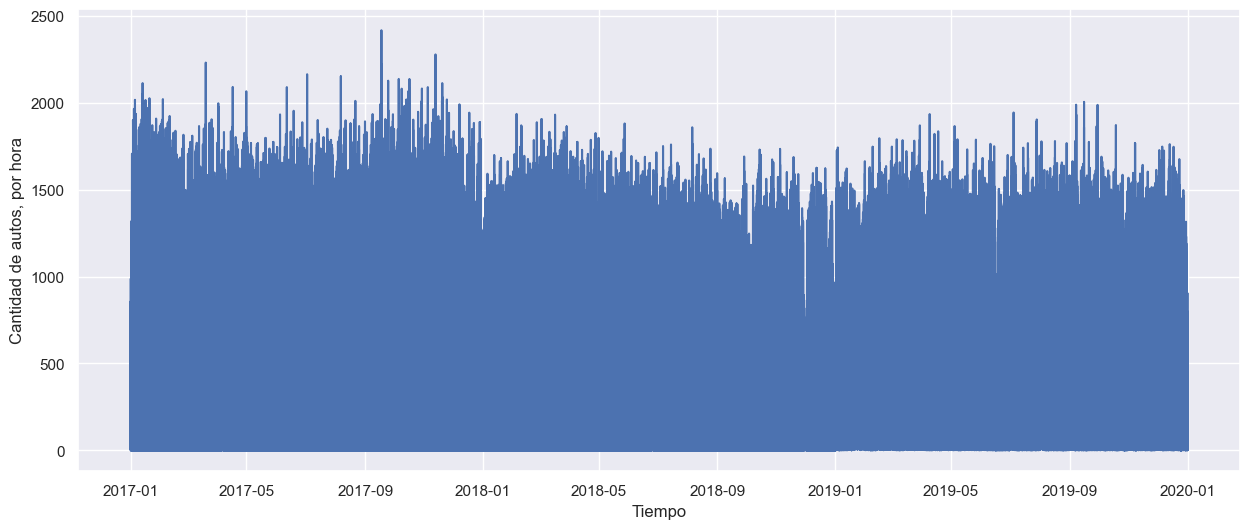

In [16]:
#Graficamos nuestros datos, tal como están
plt.figure(figsize = (15,6))
plt.plot(dataset.fecha, dataset.cantidad_pasos)
plt.xlabel('Tiempo')
plt.ylabel('Cantidad de autos, por hora')
plt.show()

In [17]:
#Resampleamos nuestros datos para agrupar por dia, y asi tal vez lograr una visualización mas amigable
diario = dataset.resample('D', on = 'fecha').sum()
print(diario.shape)
diario.head()

(1095, 1)


cantidad_pasos
fecha                     
2017-01-01           31183
2017-01-02           51568
2017-01-03           51093
2017-01-04           53332
2017-01-05           56486

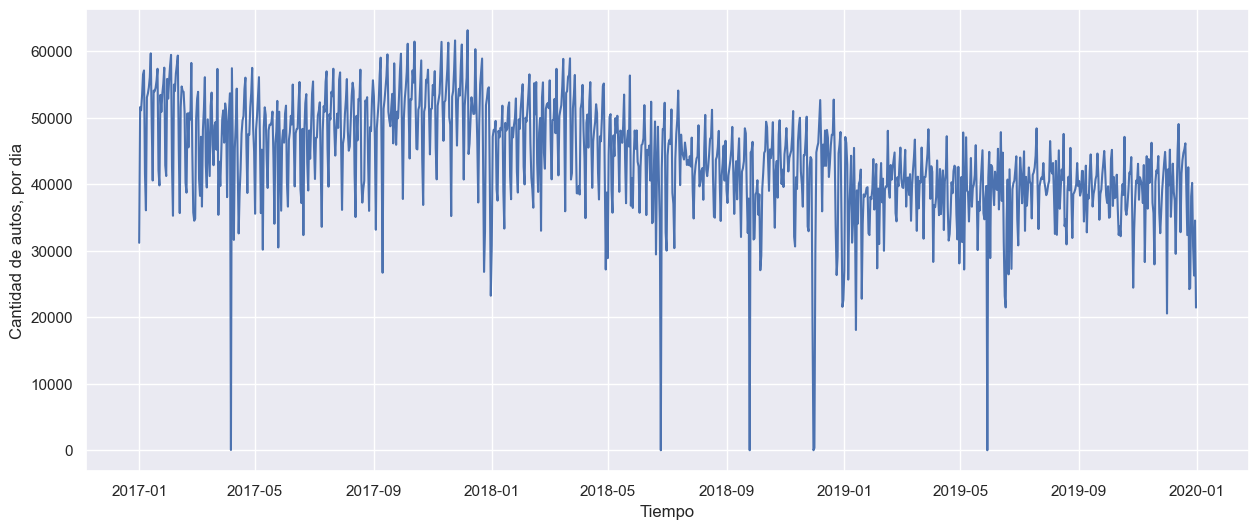

In [18]:
plt.figure(figsize = (15,6))
plt.plot(diario.index, diario.cantidad_pasos)
plt.xlabel('Tiempo')
plt.ylabel('Cantidad de autos, por dia')
plt.show()

Rápidamente se puede observar una tendencia decreciente de la cantidad de usos utilizando como metodo de pago el efectivo. A priori asumo que se explica por la migración hacia un sistema de cobro automatico asociado a una tarjeta de credito. Se observan 5 valles muy marcados, posiblemente debido a datos faltantes o 0. Los investigaremos a continuación.

# Análisis Exploratorio de Datos

Utilicemos el Profile Report para explorar nuestros datos

In [19]:
profile =  ProfileReport(diario,title = "Pandas Profiling Report")
profile

Summarize dataset:   0%|          | 0/16 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Rápidamente se observa que no se observan días faltantes (1095/3 = 365) y que no hay valores nulos. Veamos a que se deben esos valores atipicos que encontramos anteriormente

# Data Cleaning (datos faltantes y tratamiento de outliers)

## Días atipicos

In [20]:
# dias atipicos
odd= diario.loc[diario.cantidad_pasos <400]
valores_a_eliminar = odd.cantidad_pasos.unique()
valores_a_eliminar
odd

cantidad_pasos
fecha                     
2017-04-06              40
2018-06-25               0
2018-09-25               0
2018-11-30               0
2018-12-01             350
2019-05-29               0

Se observan algunos días con una extraña cantidad de pasadas. Una búsqueda en la red de cada uno de ellos revela que se deben debido a manifestaciones o accidentes que impidieron la circulacion de vehiculos. Los reemplazaremos por NaN para aplicar una interpolación 

In [21]:
#Usamos interpolacion lineal para llenar los nulos
df2 = diario.replace(valores_a_eliminar,np.nan, regex=True)
df3 = df2.interpolate(method='linear', axis=0).ffill().bfill()
df3.isnull ().sum ()

cantidad_pasos    0
dtype: int64

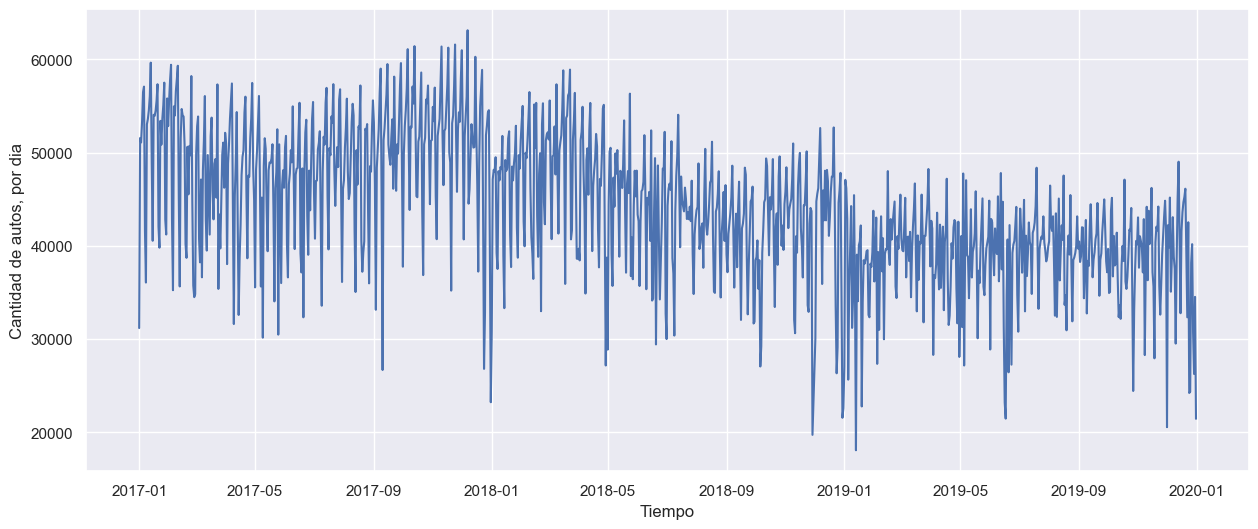

In [22]:
plt.figure(figsize = (15,6))
plt.plot(df3.index, df3.cantidad_pasos)
plt.xlabel('Tiempo')
plt.ylabel('Cantidad de autos, por dia')
plt.show()

Mucho mejor! Ya no hay quiebres abruptos en el dataset

## Detección de outliers

In [23]:
# veamos con el describe los rangos intercuartiles del dataset
df3.describe()

cantidad_pasos
count     1095.000000
mean     43918.261644
std       7579.738335
min      18076.000000
25%      39107.500000
50%      43766.000000
75%      49514.500000
max      63127.000000

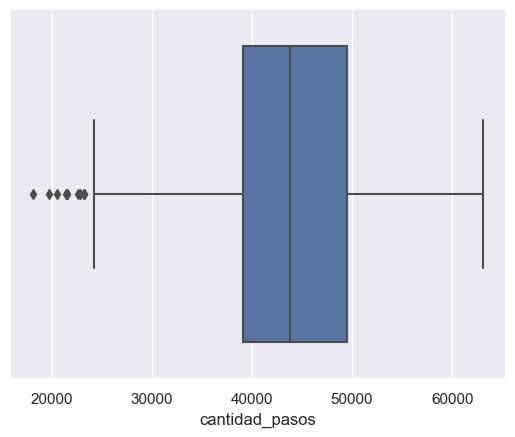

In [24]:
fig = sns.boxplot(x = df3['cantidad_pasos'])
plt.show(fig)

Se observa una distribución bastante centrada con algunos outliers importantes del  lado izquierdo, probablemente debido a choques o manifestaciones menores que interrumpieron parcialmetne el servicio. 
Utilizaremos el metodo del rango intercuartil para tratar los outliers

In [25]:
df4 = df3.copy()

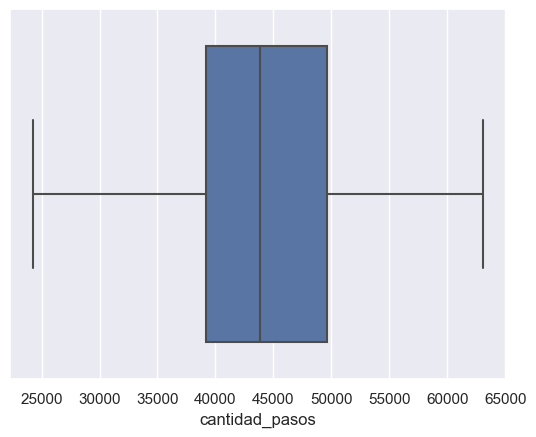

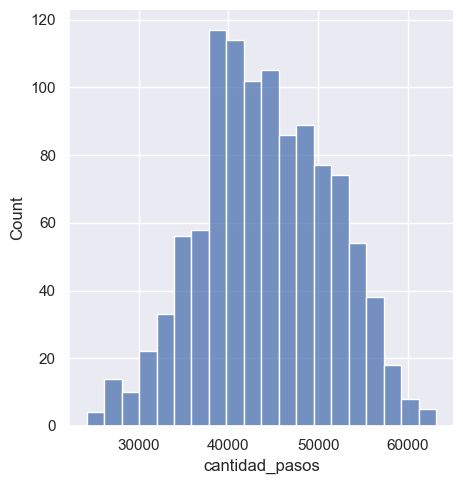

In [26]:
# tratamiento de outliers para cantidad de pasos
Q1 = df3.cantidad_pasos.quantile(0.25)
Q3 = df3.cantidad_pasos.quantile(0.75)
IQR = Q3 - Q1
df4 = df4[(df4.cantidad_pasos >= Q1 - 1.5*IQR) & (df4.cantidad_pasos <= Q3 + 1.5*IQR)]
sns.boxplot(x = df4['cantidad_pasos'])
sns.displot(df4.cantidad_pasos)
plt.show()

El tratamiento nos devolvio una distribución más normalizada

# Forecast

En primer lugar debemos renombrar nuestras columnas

In [27]:
df4.reset_index(inplace=True)
df4 = df4.rename(columns={'fecha': 'ds','cantidad_pasos': 'y'})

Antes de hacer un analisis debemos aplicar un log a la 'y' cantidad_pasos para convertir los datos en estacionarios y linealizar la tendencia.

In [28]:
#df4['y_orig'] = df4['y'] # guardamos una copia del original
# transformacion logaritmica
df4['y'] = np.log(df4['y'])

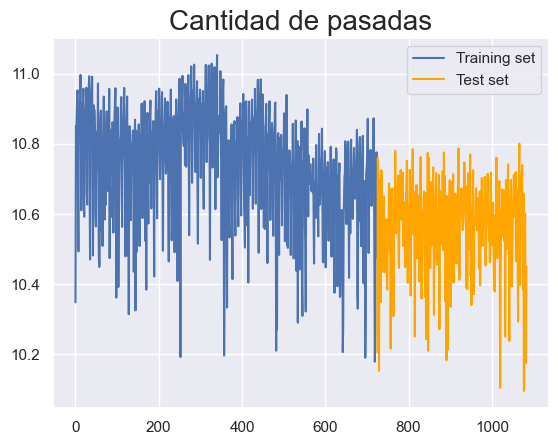

In [29]:
#definomos nuestro train y test
end_date = '2019-01-01'
mask1 = (df4['ds'] < end_date)
mask2 = (df4['ds'] >= end_date)

df_train = df4[mask1]
df_test = df4[mask2]

plt.title('Cantidad de pasadas', size=20)
plt.plot(df_train[df_train.columns[1]], label='Training set')
plt.plot(df_test[df_test.columns[1]], label='Test set', color='orange')
plt.legend()
plt.show()

Se observa el split realizado

## Benchmark ARIMA

Utilizaremos como modelo Benchmark el modelo Arima

In [41]:
#copiamos el train y el test y asignamos la variable ds como index
df_train_arima = df_train.copy()
df_test_arima = df_test.copy()
df_train_arima.set_index('ds',inplace= True)
df_test_arima.set_index('ds',inplace= True)

Entrenamos el modelo

In [43]:
arima_model = auto_arima(df_train_arima)

In [45]:
forecast_arima = pd.DataFrame(arima_model.predict(n_periods= len(df_test_arima)),index = df_test_arima.index)
forecast_arima.columns = ['yhat_arima']
cantidad_pasadas = df_test_arima['y']
forecast_arima = forecast_arima.join(cantidad_pasadas)
forecast_arima.sample(5)

yhat_arima          y
ds                               
2019-08-12   10.576369  10.499435
2019-08-08   10.681617  10.680240
2019-02-10   10.632314  10.616829
2019-07-31   10.713251  10.594232
2019-04-25   10.525930  10.663616

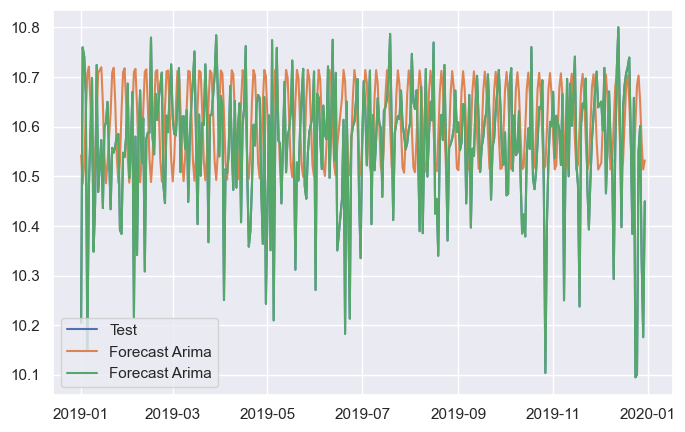

In [46]:
plt.figure(figsize=(8,5))
plt.plot(df_test_arima,label='Test')
plt.plot(forecast_arima,label='Forecast Arima')
plt.legend(loc = 'lower left')
plt.show()

 <span style="color:red">Rápidamente se observa que el modelo propuesto no es muy bueno y puede mejorarse. Consideremos algunas metricas para saber de cuanto error estamos hablando

# <span style="color:red">Metricas</span>.
    
<span style="color:red">Utilizaremos dos metricas para evaluar todos nuestros modelos:
    
    
<span style="color:red">RMSE — Root Mean Squared Error
    
<span style="color:red">MAPE — Mean Absolute Percentage Error</span>.
    

<span style="color:red">El RMSE nos dira cuantas el error promedio en cantidad de pasadas que podemos esperar en cada forecast

<span style="color:red">El MAPE nos dira el porcentaje del error, muy similar al accuracy en los problemas de clasificaciòn.Por ejemplo: si obtenemos un MAPE= 0.05 nuestro modelo es 95% correcto.</span>.



In [47]:
mape_arima = mean_absolute_percentage_error(np.exp(df_test['y']),np.exp(forecast_arima['yhat_arima']))
print("MAPE ARIMA",round(mape_arima,4))

MAPE ARIMA 0.1243


In [48]:
rmse_test_arima = np.sqrt(mean_squared_error(np.exp(df_test['y']),np.exp(forecast_arima['yhat_arima'])))
print("RMSE",round(rmse_test_arima,1))

RMSE 5720.7


<span style="color:red">Si bien no son metricas muy malas, creo que pueden mejorarse considerablemente una vez que empecemos a jugar con los hiperparametros

# Forecast utilizando fb Prophet

<span style="color:red">Modelemos ahora utilizando el Prophet

In [30]:
#fitteamos el modelo con el df_train
model = Prophet(yearly_seasonality = True)
model.fit(df_train)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [31]:
#creamos las predicciones para el año siguiente
future = model.make_future_dataframe(periods = 367, freq = 'D')

In [32]:
#predicciones
forecast = model.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]

ds       yhat  yhat_lower  yhat_upper
0    2017-01-01  10.609238   10.484511   10.730688
1    2017-01-02  10.784728   10.662065   10.913735
2    2017-01-03  10.810043   10.679119   10.937062
3    2017-01-04  10.854148   10.730833   10.972320
4    2017-01-05  10.884621   10.756152   11.015784
...         ...        ...         ...         ...
1087 2019-12-27  10.520468   10.218643   10.829615
1088 2019-12-28  10.313433   10.000105   10.616785
1089 2019-12-29  10.171598    9.868981   10.490669
1090 2019-12-30  10.346105   10.050170   10.660306
1091 2019-12-31  10.370283   10.078530   10.687266

[1092 rows x 4 columns]

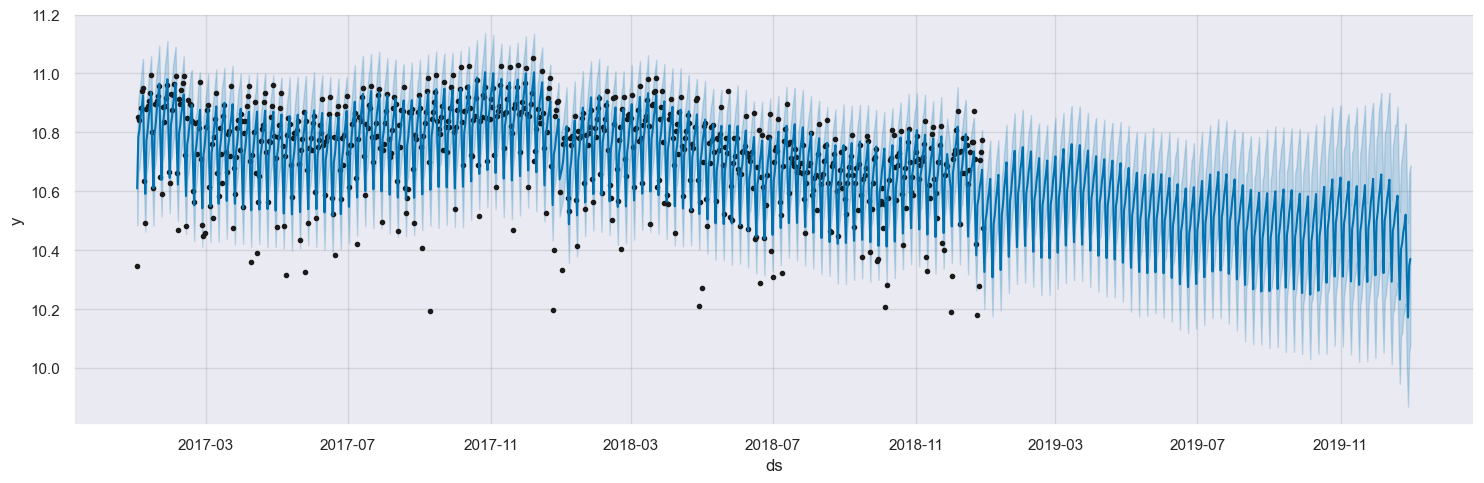

In [33]:
# Gráficamos el forecast
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
fig = model.plot(forecast,ax=ax)
plt.show()

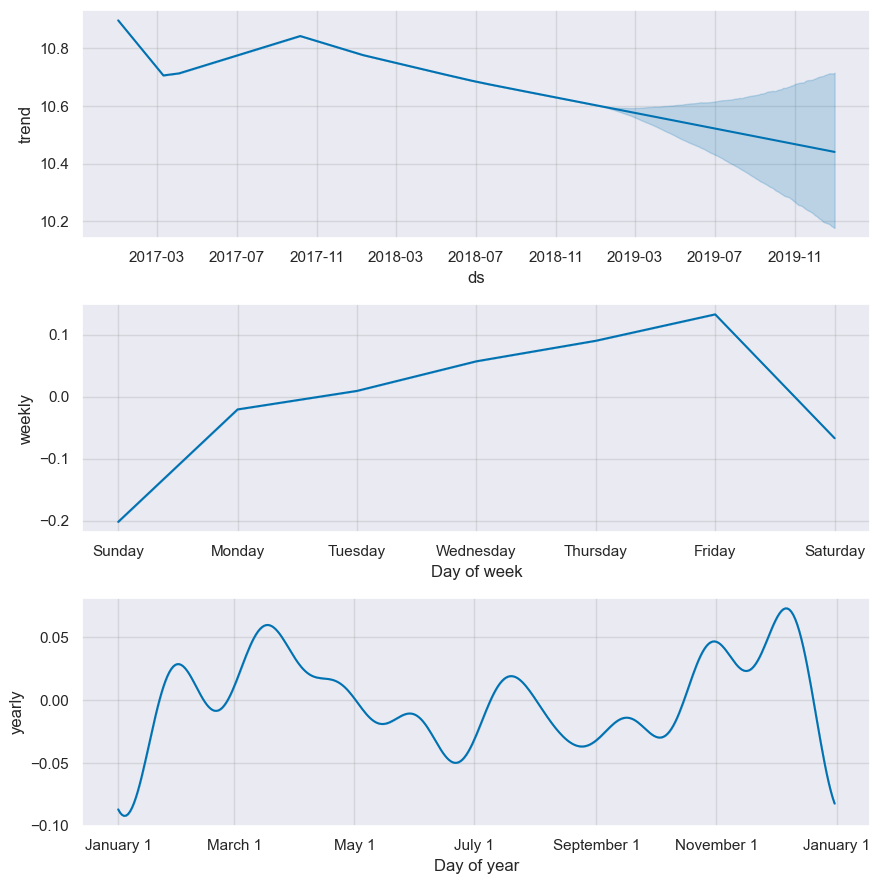

In [34]:
# Gráficamos las componentes del modelo
fig = model.plot_components(forecast)
plt.show(fig)

Semanalmente se observa un crecimiento sostenido a medida que avanza la semana, alcanzando su pico los dias viernes. Este es el día en el que muchos porteños, cansados de la ciudad se escapan a las afueras de Buenas Aires para respirar un poco de aire puro y desestresarse. Eso, y la poca actividad laboral, explican la abrupta caída los fines de semana. 

Por ultimo, anualmente se observan fluctuaciones importantes, altamente relacionados con la estacion del año y probablemente la temperatura, incluso hasta parece estar relacionado con el calendario escolar, con recesos en julio y a partir de diciembre hasta marzo.

## Changepoints
Un changepoint representa un cambio significante en la serie de tiempo.
Seteamos changepoints = 4 para observarlo en la serie de tiempo

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


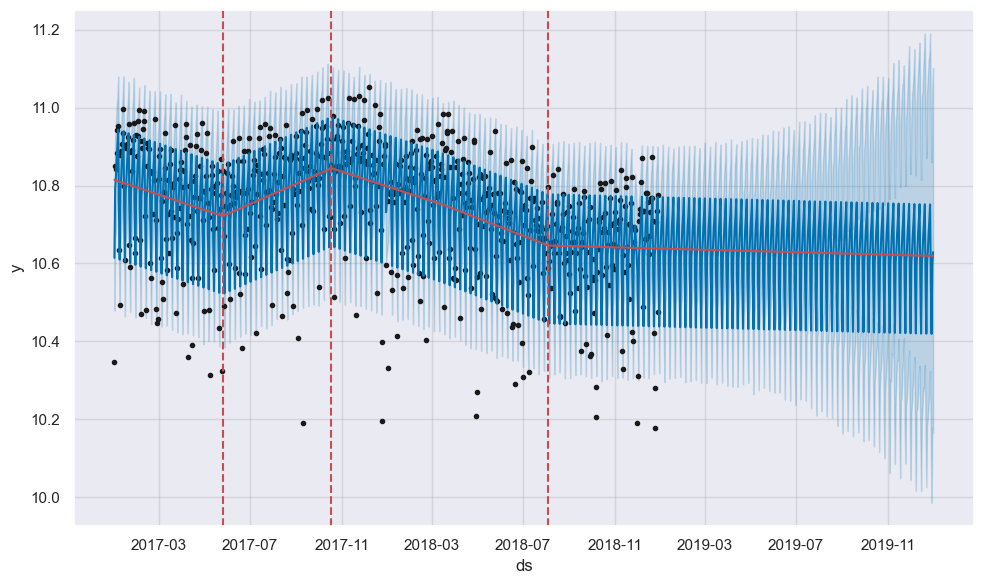

In [35]:
from fbprophet.plot import add_changepoints_to_plot
pro_change= Prophet(n_changepoints=4)
forecast = pro_change.fit(df_train).predict(future)
fig= pro_change.plot(forecast);
add_changepoints_to_plot(fig.gca(), pro_change, forecast)
fig

Se observa una abrupta caida en la cantidad de pasos en efectivo a en el 2018 y una caida mas suave en el año 2019. Como toda tecnología hay quienes rápidamente adoptan el cambio (generalmente la población jóven), y por el otro lado tenemos gente que no sabe o no le interesa modificar su metodo de pago.

# Real vs proyectado

In [36]:
#tabla con el forecast
df_test_forecast = model.predict(df_test)
df_test_forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

ds       yhat  yhat_lower  yhat_upper
354 2019-12-26  10.486367   10.194211   10.775809
355 2019-12-27  10.520468   10.213127   10.798549
356 2019-12-28  10.313433   10.010353   10.602925
357 2019-12-29  10.171598    9.862230   10.460152
358 2019-12-30  10.346105   10.033098   10.641300

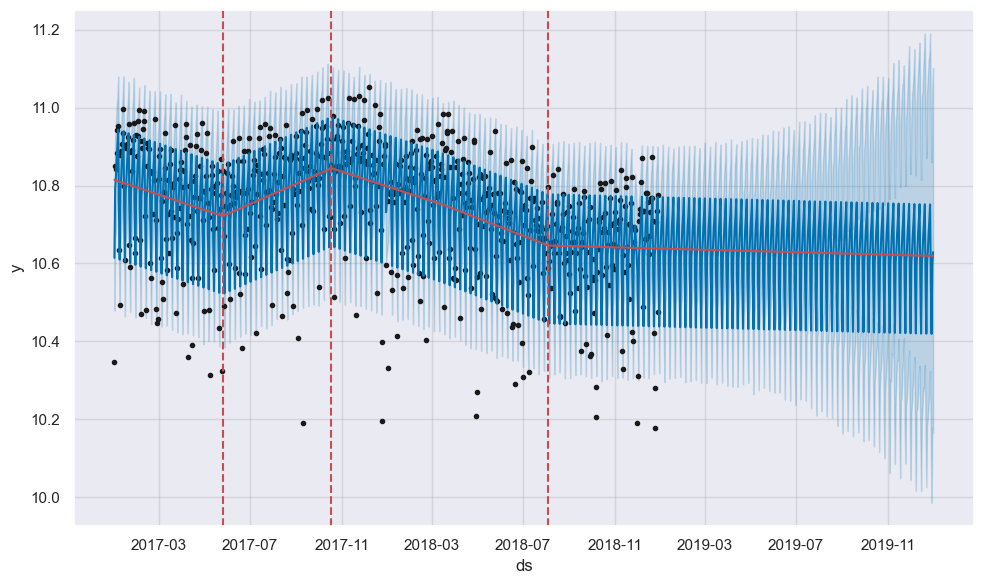

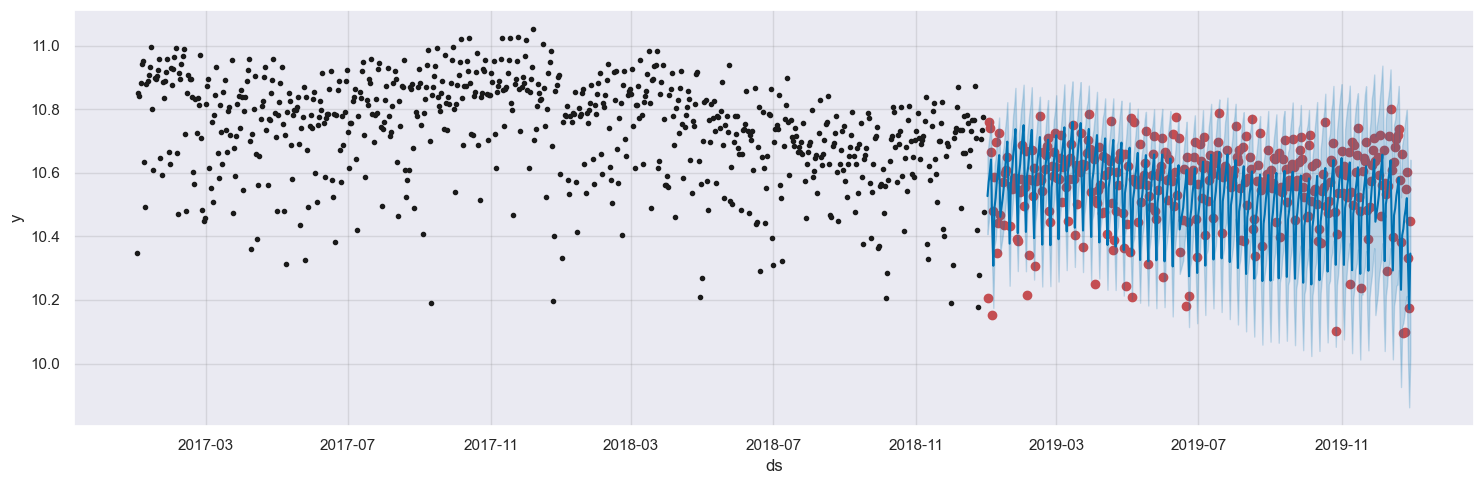

In [37]:
# Gráficamos el forecast con los actuales
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
ax.scatter(df_test.ds, df_test['y'], color='r')
fig = model.plot(df_test_forecast, ax=ax)
plt.show(fig)

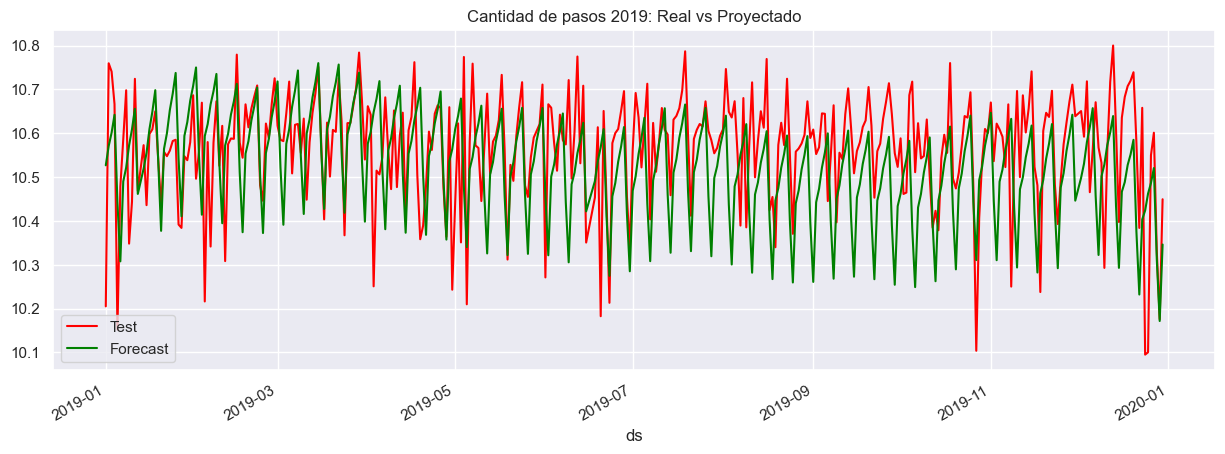

In [38]:
f, ax = plt.subplots(figsize=(14,5))
f.set_figheight(5)
f.set_figwidth(15)
df_test.plot(kind='line',x='ds', y='y', color='red', label='Test', ax=ax)
df_test_forecast.plot(kind='line',x='ds',y='yhat', color='green',label='Forecast', ax=ax)
plt.title('Cantidad de pasos 2019: Real vs Proyectado')
plt.show()

Del ùltimo grafico se observa que hay un spread importante entre las predicciones y lo real. Por lo tanto debemo optimizar nuestros modelo. Calculmemos las metricas del modelo actual para compararlo con el optimizado.

In [39]:
mape = mean_absolute_percentage_error(np.exp(df_test['y']),np.exp(df_test_forecast['yhat']))
print("MAPE",round(mape,4))

MAPE 0.1075


In [40]:
rmse_test = np.sqrt(mean_squared_error(np.exp(df_test['y']),np.exp(df_test_forecast['yhat'])))
print("RMSE",round(rmse_test,1))

RMSE 5226.0


# Importación de feriados Argentina
Veamos si el modelo mejora considerando los feriados

In [49]:
import holidays
holiday = pd.DataFrame([])
for date, name in sorted(holidays.Argentina(years=[2018,2019,2020]).items()):
    holiday = holiday.append(pd.DataFrame({'ds': date, 'holiday': "AR-Holidays"}, index=[0]), ignore_index=True)
holiday['ds'] = pd.to_datetime(holiday['ds'], format='%Y-%m-%d', errors='ignore')

In [50]:
holiday.sample(5)

ds      holiday
31 2019-08-17  AR-Holidays
3  2018-03-24  AR-Holidays
8  2018-05-01  AR-Holidays
53 2020-12-25  AR-Holidays
23 2019-04-18  AR-Holidays

In [51]:
# Entrenamiento del modelo con feriados
model_with_holidays = Prophet(holidays=holiday)
model_with_holidays.fit(df_train)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [52]:
future = model_with_holidays.make_future_dataframe(periods=359, freq='D')
forecast = model_with_holidays.predict(future)

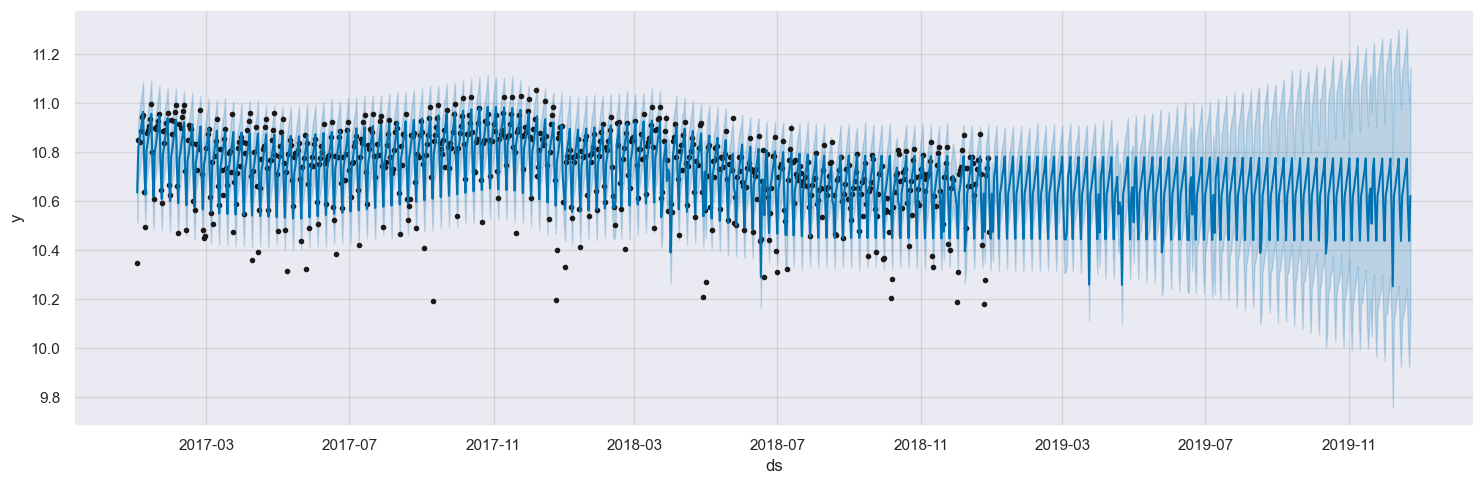

In [53]:
# Plot the forecast
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
fig = model_with_holidays.plot(forecast,ax=ax)
plt.show(fig)

In [54]:
df_test_forecast_holiday = model_with_holidays.predict(df_test)

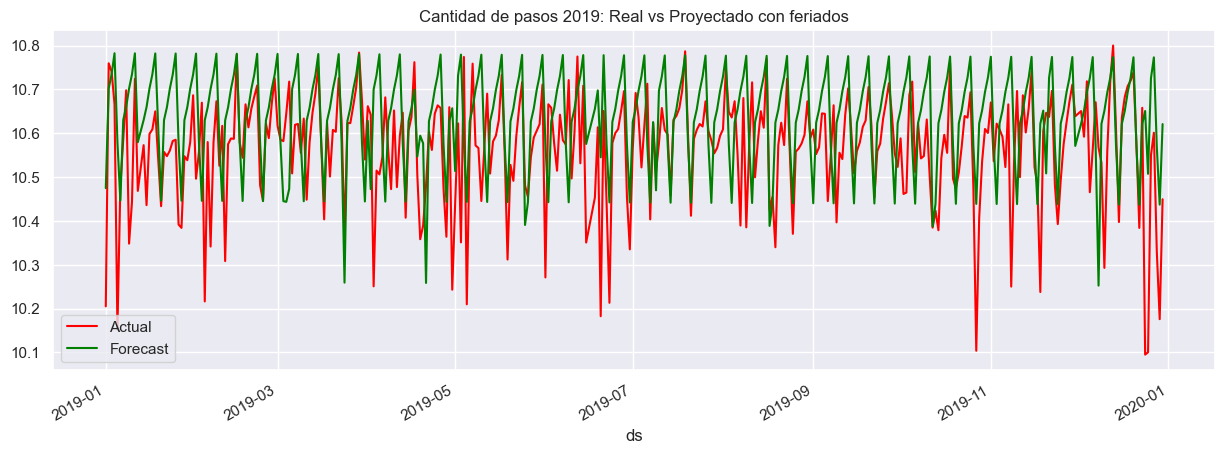

In [55]:
f, ax = plt.subplots(figsize=(14,5))
f.set_figheight(5)
f.set_figwidth(15)
df_test.plot(kind='line',x='ds', y='y', color='red', label='Actual', ax=ax)
df_test_forecast_holiday.plot(kind='line',x='ds',y='yhat', color='green',label='Forecast', ax=ax)
plt.title('Cantidad de pasos 2019: Real vs Proyectado con feriados')
plt.show()

No se observa una mejora en los graficos, veamos que nos dicen las metricas

In [56]:
mape_holiday = mean_absolute_percentage_error(np.exp(df_test['y']),np.exp(df_test_forecast_holiday['yhat']))
print("MAPE con feriados",round(mape_holiday,4))

MAPE con feriados 0.1206


In [57]:
rmse_test_holiday = np.sqrt(mean_squared_error(np.exp(df_test['y']),np.exp(df_test_forecast_holiday['yhat'])))
print("RMSE con feriados",round(rmse_test_holiday,1))

RMSE con feriados 5622.4


De los resultaods expuestos anteriormente se observa que al añadir los feriados al modelo reduce su rendimiento. Necesitamos agregar otros parametros y optimizarlos para maximizar el rendimiento del modelo.

Trabajaremos con los hiperparametros seasonality_mode, changepoint_prior_scale, holiday_prior_scale, n_changepoints

# Optimizacion de hiperparametros utilizando ParameterGrid

In [58]:
from sklearn.model_selection import ParameterGrid
params_grid = {'seasonality_mode':('multiplicative','additive'),
               'changepoint_prior_scale':[0.1,0.2,0.3,0.4,0.5],
              'holidays_prior_scale':[0.1,0.2,0.3,0.4,0.5],
              'n_changepoints' : [100,150,200]}
grid = ParameterGrid(params_grid)
cnt = 0
for p in grid:
    cnt = cnt+1

print('Cantidad de modelos posibles',cnt)

Cantidad de modelos posibles 150


In [59]:
import random 
strt='2018-12-31'
end='2019-12-30'
model_parameters = pd.DataFrame(columns = ['MAPE','Parameters'])
for p in grid:
    test = pd.DataFrame()
    print(p)
    random.seed(0)
    train_model =Prophet(changepoint_prior_scale = p['changepoint_prior_scale'],
                         holidays_prior_scale = p['holidays_prior_scale'],
                         n_changepoints = p['n_changepoints'],
                         seasonality_mode = p['seasonality_mode'],
                         weekly_seasonality=True,
                         daily_seasonality = True,
                         yearly_seasonality = True,
                         holidays=holiday, 
                         interval_width=0.95)
    train_model.add_country_holidays(country_name='AR')
    train_model.fit(df_train)
    train_forecast = train_model.make_future_dataframe(periods=359, freq='D',include_history = False)
    train_forecast = train_model.predict(train_forecast)
    test=train_forecast[['ds','yhat']]
    Actual = df4[(df4['ds']>strt) & (df4['ds']<=end)]
    MAPE = mean_absolute_percentage_error(Actual['y'],abs(test['yhat']))
    print('Mean Absolute Percentage Error(MAPE)------------------------------------',MAPE)
    model_parameters = model_parameters.append({'MAPE':MAPE,'Parameters':p},ignore_index=True)

{'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 0.1, 'n_changepoints': 100, 'seasonality_mode': 'multiplicative'}
Mean Absolute Percentage Error(MAPE)------------------------------------ 0.016978477760124556
{'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 0.1, 'n_changepoints': 100, 'seasonality_mode': 'additive'}
Mean Absolute Percentage Error(MAPE)------------------------------------ 0.012678453497788553
{'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 0.1, 'n_changepoints': 150, 'seasonality_mode': 'multiplicative'}
Mean Absolute Percentage Error(MAPE)------------------------------------ 0.016845918538275495
{'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 0.1, 'n_changepoints': 150, 'seasonality_mode': 'additive'}
Mean Absolute Percentage Error(MAPE)------------------------------------ 0.013274493284401974
{'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 0.1, 'n_changepoints': 200, 'seasonality_mode': 'multiplicative'}
Mean Absolute Percent

Mean Absolute Percentage Error(MAPE)------------------------------------ 0.04805847402777662
{'changepoint_prior_scale': 0.2, 'holidays_prior_scale': 0.2, 'n_changepoints': 150, 'seasonality_mode': 'additive'}
Mean Absolute Percentage Error(MAPE)------------------------------------ 0.024568131735305823
{'changepoint_prior_scale': 0.2, 'holidays_prior_scale': 0.2, 'n_changepoints': 200, 'seasonality_mode': 'multiplicative'}
Mean Absolute Percentage Error(MAPE)------------------------------------ 0.04723167300892843
{'changepoint_prior_scale': 0.2, 'holidays_prior_scale': 0.2, 'n_changepoints': 200, 'seasonality_mode': 'additive'}
Mean Absolute Percentage Error(MAPE)------------------------------------ 0.02000646771821994
{'changepoint_prior_scale': 0.2, 'holidays_prior_scale': 0.3, 'n_changepoints': 100, 'seasonality_mode': 'multiplicative'}
Mean Absolute Percentage Error(MAPE)------------------------------------ 0.053050337357045604
{'changepoint_prior_scale': 0.2, 'holidays_prior_scal

Mean Absolute Percentage Error(MAPE)------------------------------------ 0.023493281068154626
{'changepoint_prior_scale': 0.3, 'holidays_prior_scale': 0.4, 'n_changepoints': 100, 'seasonality_mode': 'multiplicative'}
Mean Absolute Percentage Error(MAPE)------------------------------------ 0.07711969276382603
{'changepoint_prior_scale': 0.3, 'holidays_prior_scale': 0.4, 'n_changepoints': 100, 'seasonality_mode': 'additive'}
Mean Absolute Percentage Error(MAPE)------------------------------------ 0.02853477047268401
{'changepoint_prior_scale': 0.3, 'holidays_prior_scale': 0.4, 'n_changepoints': 150, 'seasonality_mode': 'multiplicative'}
Mean Absolute Percentage Error(MAPE)------------------------------------ 0.05348416240420112
{'changepoint_prior_scale': 0.3, 'holidays_prior_scale': 0.4, 'n_changepoints': 150, 'seasonality_mode': 'additive'}
Mean Absolute Percentage Error(MAPE)------------------------------------ 0.023078517464844146
{'changepoint_prior_scale': 0.3, 'holidays_prior_scal

Mean Absolute Percentage Error(MAPE)------------------------------------ 0.0788029582017638
{'changepoint_prior_scale': 0.4, 'holidays_prior_scale': 0.5, 'n_changepoints': 150, 'seasonality_mode': 'additive'}
Mean Absolute Percentage Error(MAPE)------------------------------------ 0.020279894107867635
{'changepoint_prior_scale': 0.4, 'holidays_prior_scale': 0.5, 'n_changepoints': 200, 'seasonality_mode': 'multiplicative'}
Mean Absolute Percentage Error(MAPE)------------------------------------ 0.07870251995153023
{'changepoint_prior_scale': 0.4, 'holidays_prior_scale': 0.5, 'n_changepoints': 200, 'seasonality_mode': 'additive'}
Mean Absolute Percentage Error(MAPE)------------------------------------ 0.017748413937909564
{'changepoint_prior_scale': 0.5, 'holidays_prior_scale': 0.1, 'n_changepoints': 100, 'seasonality_mode': 'multiplicative'}
Mean Absolute Percentage Error(MAPE)------------------------------------ 0.08624508054080982
{'changepoint_prior_scale': 0.5, 'holidays_prior_scale

In [60]:
#ordenamos los resultados por MAPE
parameters = model_parameters.sort_values(by=['MAPE'])
parameters = parameters.reset_index(drop=True)
parameters.head()

MAPE                                         Parameters
0  0.012678  {'changepoint_prior_scale': 0.1, 'holidays_pri...
1  0.012698  {'changepoint_prior_scale': 0.1, 'holidays_pri...
2  0.012700  {'changepoint_prior_scale': 0.1, 'holidays_pri...
3  0.012738  {'changepoint_prior_scale': 0.1, 'holidays_pri...
4  0.012789  {'changepoint_prior_scale': 0.1, 'holidays_pri...

De los 150 modelos seleccionaremos aquelos parametros que mostraron el mejor MAPE para entrnar el modelo final y predecir el año 2019

Los mejores parametros con el mejor MAPE son:

In [61]:
parameters['Parameters'][0]

{'changepoint_prior_scale': 0.1,
 'holidays_prior_scale': 0.1,
 'n_changepoints': 100,
 'seasonality_mode': 'additive'}

In [62]:
# Entrenamiento del modelo optimizando
final_model = Prophet(holidays=holiday,
                      changepoint_prior_scale= 0.1,
                      holidays_prior_scale = 0.1,
                      n_changepoints = 100,
                      seasonality_mode = 'additive',
                      weekly_seasonality=True,
                      daily_seasonality = True,
                      yearly_seasonality = True,
                      interval_width=0.95)
final_model.add_country_holidays(country_name='AR')
final_model.fit(df_train)

In [63]:
future = final_model.make_future_dataframe(periods=367, freq='D')
forecast = final_model.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(7)

ds       yhat  yhat_lower  yhat_upper
1085 2019-12-25  10.233810    9.685592   10.778436
1086 2019-12-26  10.590718   10.063351   11.128619
1087 2019-12-27  10.634565   10.079619   11.156451
1088 2019-12-28  10.417093    9.897530   10.966304
1089 2019-12-29  10.279662    9.724281   10.825109
1090 2019-12-30  10.467875    9.916599   11.012913
1091 2019-12-31  10.488100    9.947241   11.026127

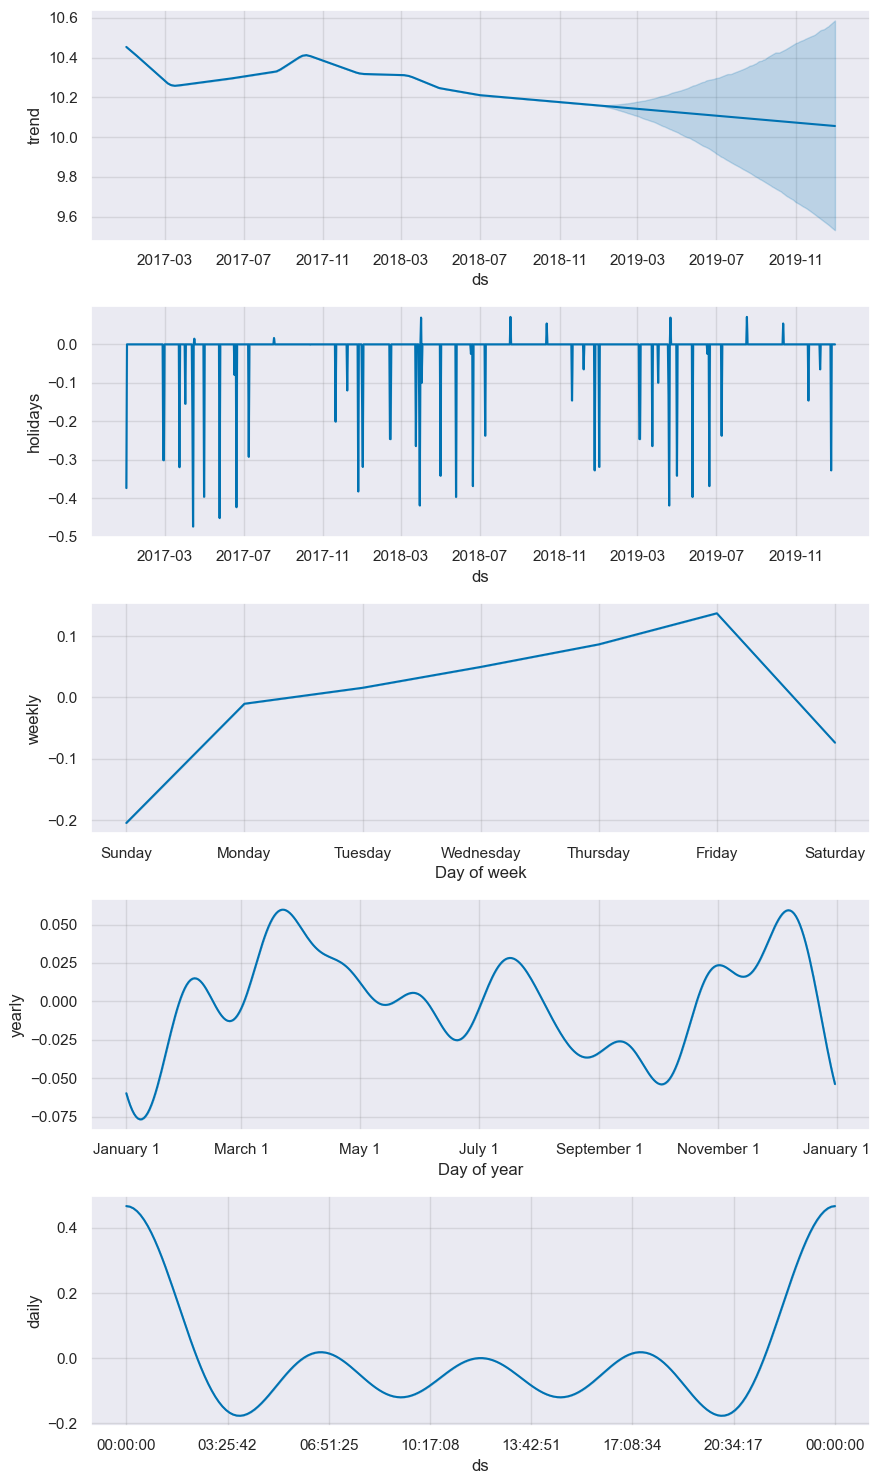

In [64]:
#graficamos las componentes
fig = final_model.plot_components(forecast)
plt.show(fig)

Las componentes muestran un comportamiento similar al estudiado anteriormente. Se incoorpora el analisis de los feriados y el diario.

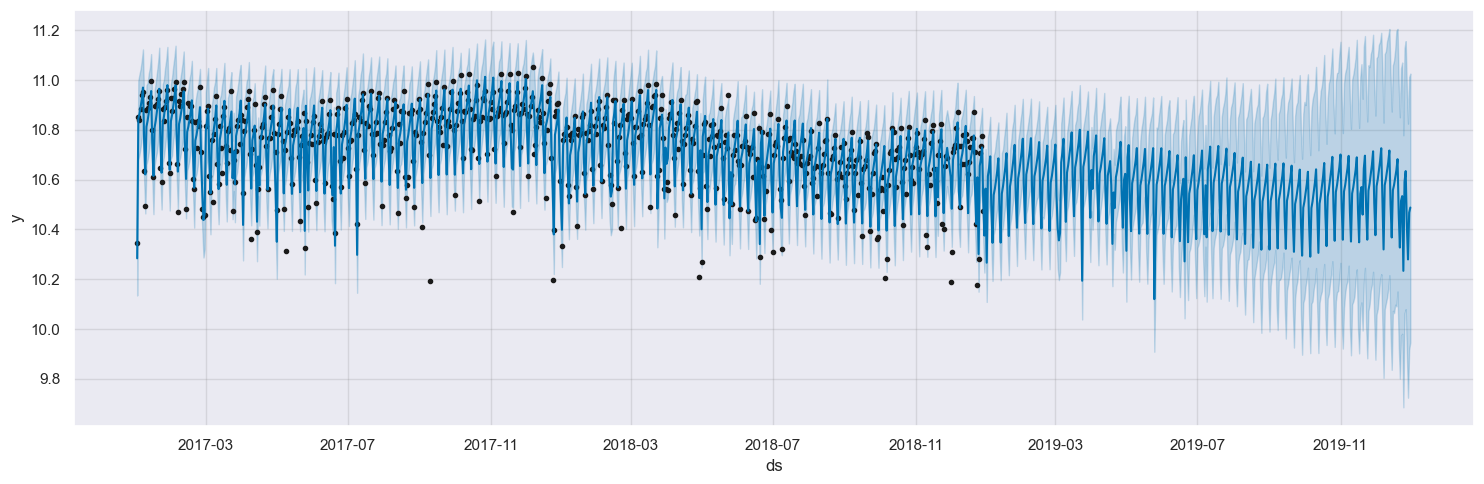

In [65]:
# Grafiquemos el forecast
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
fig = final_model.plot(forecast,ax=ax)
plt.show()

In [66]:
X_test_final= final_model.predict(df_test)
X_test_final[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(5)

ds       yhat  yhat_lower  yhat_upper
354 2019-12-26  10.590718   10.063396   11.089006
355 2019-12-27  10.634565   10.108026   11.123476
356 2019-12-28  10.417093    9.890685   10.912814
357 2019-12-29  10.279662    9.749398   10.767832
358 2019-12-30  10.467875    9.944204   10.961548

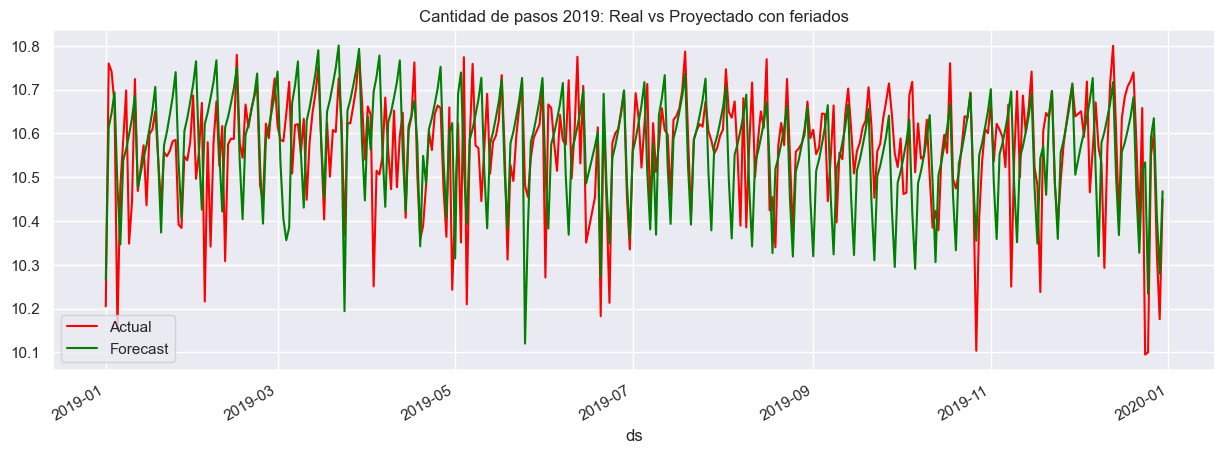

In [67]:
f, ax = plt.subplots(figsize=(14,5))
f.set_figheight(5)
f.set_figwidth(15)
df_test.plot(kind='line',x='ds', y='y', color='red', label='Actual', ax=ax)
X_test_final.plot(kind='line',x='ds',y='yhat', color='green',label='Forecast', ax=ax)
plt.title('Cantidad de pasos 2019: Real vs Proyectado con feriados')
plt.show()

Se observa cierta mejora con respecto al modelo anterior aunque todavia hay algunas diferencias, particularmente en los valores extremos.

In [68]:
MAPE_FINAL = mean_absolute_percentage_error(np.exp(df_test['y']),np.exp(X_test_final['yhat']))
print('MAPE FINAL', round(MAPE_FINAL,3))

MAPE FINAL 0.095


In [69]:
rmse_test_final = np.sqrt(mean_squared_error(np.exp(df_test['y']),np.exp(X_test_final['yhat'])))
print("RMSE",round(rmse_test_final,1))

RMSE 4847.3


In [71]:
metricas= [[mape_arima,rmse_test_arima],
        [mape,rmse_test],
        [mape_holiday, rmse_test_holiday],
        [MAPE_FINAL, rmse_test_final]]


columnas = ['MAPE', 'RMSE'] # definimos los nombres de las columnas
filas = [ 'Modelo Benchmark(Arima)','Modelo inicial', 'Modelo con feriados','Modelo optimizado',] # definimos los nombres de las filas

comparacion2 = pd.DataFrame(metricas, columns=columnas, index=filas)
comparacion2

MAPE         RMSE
Modelo Benchmark(Arima)  0.124291  5720.720672
Modelo inicial           0.107501  5226.014937
Modelo con feriados      0.120571  5622.362355
Modelo optimizado        0.094683  4847.326891

Se observa que con la optimización de los hiperparametros hemos podido mejorar un 10% el modelo inicial y una mejora aun mayor con respecto al modelo benchmark.

## Predicción del año 2020

Utilizaremos el modelo creado para predecir la cantidad de pasadas del año 2020. Primero debemos hacer las mismas modificaciones que hicimos para los otros datasets.

In [72]:
data_2020 = pd.read_csv(r'C:\Users\guido\Downloads\flujo-vehicular-2020.csv', sep =',')

In [73]:
#Nos quedamos solamente con la estación Illia y la forma de pago Efectivo
mask = np.logical_and(data_2020.estacion=='ILLIA', data_2020.forma_pago == 'Efectivo')
data_2020 = data_2020[mask]

#Quitamos las columnas que no vamos a utilizar
data_2020.drop(columns = ['periodo','hora_inicio','forma_pago', 'estacion'], inplace = True)

#Pasamos la columna fecha a formato datetime, y le unimos la hora_fin como hora
data_2020['fecha2'] = pd.to_datetime(data_2020.fecha) + pd.to_timedelta(data_2020.hora_fin, unit = 'h')

#Quitamos las columnas fecha y hora_fin ya que las incluimos en el campo fecha2
data_2020.drop(columns=['fecha','hora_fin'], inplace = True)

#Corregimos el nombre de fecha2 a fecha
data_2020.rename(columns = {'fecha2':'fecha'}, inplace = True) 

#Reordenamos el dataset por fecha
data_2020.sort_values('fecha', inplace = True)
data_2020.reset_index(drop=True, inplace = True)

#Resampleamos nuestros datos para agrupar por dia, y asi tal vez lograr una visualización mas amigable
df_test_2020 = data_2020.resample('D', on = 'fecha').sum()
print(df_test_2020.shape)
df_test_2020.head()

(366, 2)


dia_fecha  cantidad_pasos
fecha                                
2020-01-01      184.0         21395.0
2020-01-02      408.0         33722.0
2020-01-03      618.0         37067.0
2020-01-04      824.0         30627.0
2020-01-05     1085.0         27812.0

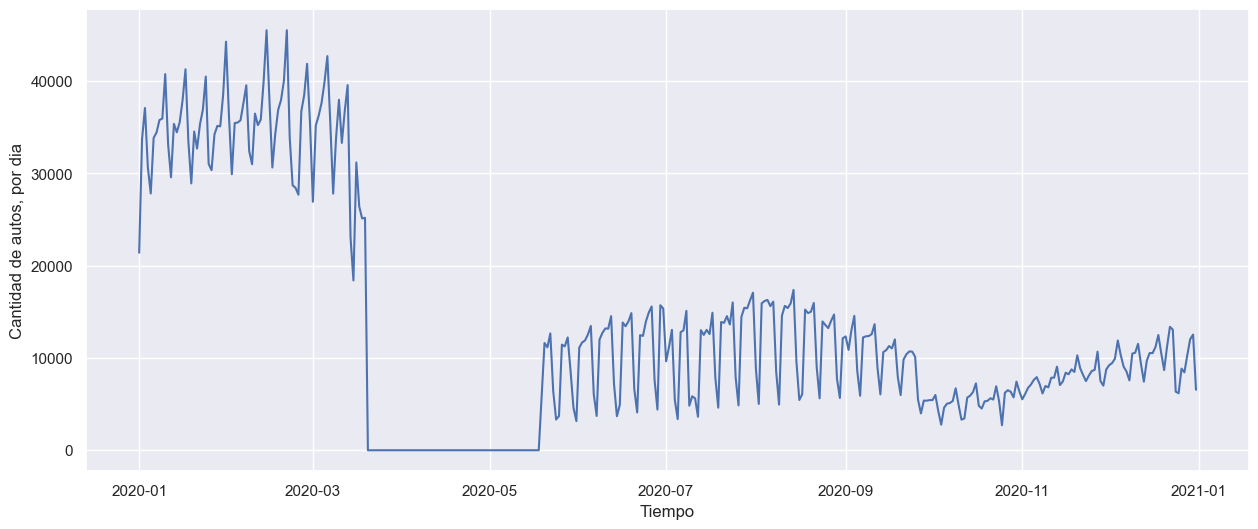

In [74]:
plt.figure(figsize = (15,6))
plt.plot(df_test_2020.index, df_test_2020.cantidad_pasos)
plt.xlabel('Tiempo')
plt.ylabel('Cantidad de autos, por dia')
plt.show()

Se observa un gran vacio en los datos entre abril y mayo. Debido a la pandemia las barreras de los peajes estuvieron levantadas y no contaron las pasadas. Posteriormente se observa una lenta recuperacion del nivel de pasadas, debido a las restricciones de circulacion y la implementacion del trabajo remoto. Utilizaremos interpolacion linear para completarla pero lamentablemente va aafectar considerablemente el rendimiento del modelo

In [75]:
# dias atipicos
odd= df_test_2020.loc[df_test_2020.cantidad_pasos <400]
valores_a_eliminar = odd.cantidad_pasos.unique()
valores_a_eliminar

array([0., 1.])

In [76]:
df_test_2020 = df_test_2020.replace(valores_a_eliminar,np.nan, regex=True)

# Agregar las fechas faltantes

In [77]:
#Usamos interpolacion lineal para llenar los nulos
df_test_2020 = df_test_2020.interpolate(method='linear', axis=0).ffill().bfill()
df_test_2020.isnull ().sum ()

dia_fecha         0
cantidad_pasos    0
dtype: int64

In [2]:
plt.figure(figsize = (15,6))
plt.plot(df_test_2020.index, df_test_2020.cantidad_pasos)
plt.xlabel('Tiempo')
plt.ylabel('Cantidad de autos, por dia')
plt.show()

NameError: name 'plt' is not defined

Como vemos la interpolacion no es no refleja las verdaderas fluctuaciones y por lo tanto afectara el rendimiento del modelo

In [79]:
df_test_2020.reset_index(inplace=True)
df_test_2020 = df_test_2020.rename(columns={'fecha': 'ds','cantidad_pasos': 'y'})

In [1]:
df_test_2020['y_orig'] = df_test_2020['y'] # guardamos una copia del original
# transformacion logaritmica
df_test_2020['y'] = np.log(df_test_2020['y'])
df_test_2020

NameError: name 'df_test_2020' is not defined

In [81]:
# Entrenamiento del modelo optimizando
final_model = Prophet(holidays=holiday,
                      changepoint_prior_scale= 0.1,
                      holidays_prior_scale = 0.1,
                      n_changepoints = 100,
                      seasonality_mode = 'additive',
                      weekly_seasonality=True,
                      daily_seasonality = True,
                      yearly_seasonality = True,
                      interval_width=0.95)
final_model.add_country_holidays(country_name='AR')
final_model.fit(df4)

In [82]:
future = final_model.make_future_dataframe(periods=367, freq='D')
forecast = final_model.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(5)

ds       yhat  yhat_lower  yhat_upper
1446 2020-12-27  10.122918    9.820251   10.441220
1447 2020-12-28  10.262732    9.955202   10.583019
1448 2020-12-29  10.278744    9.971983   10.599045
1449 2020-12-30  10.304167   10.000798   10.622931
1450 2020-12-31  10.329285   10.010577   10.647681

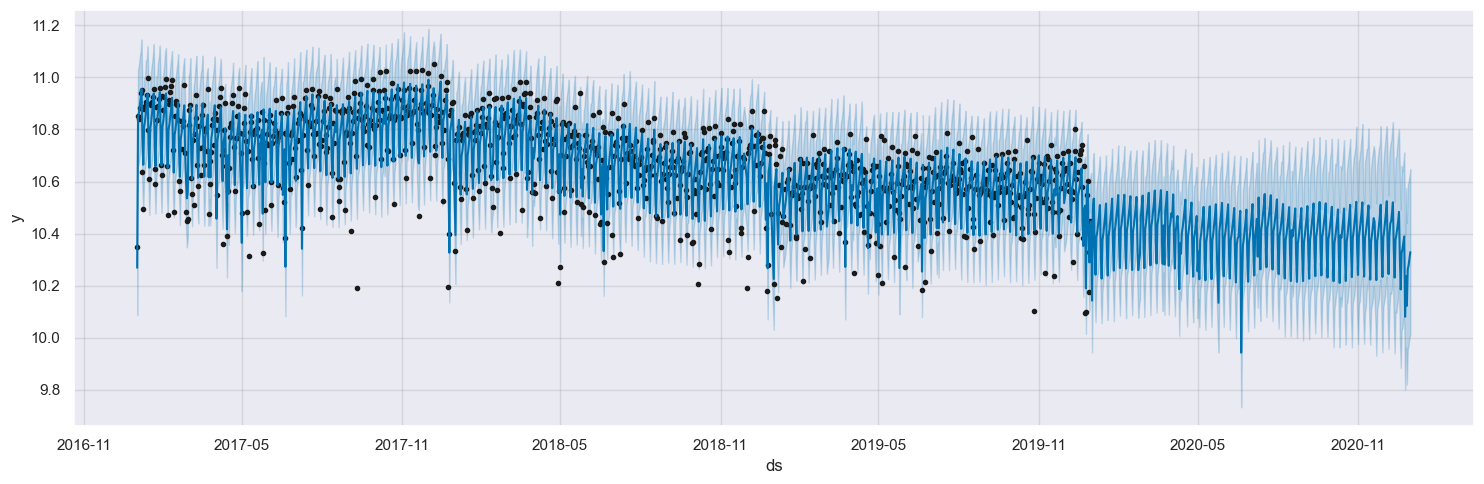

In [83]:
# Graficamos el forecast
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
fig = final_model.plot(forecast,ax=ax)
plt.show()

In [84]:
X_test_final= final_model.predict(df_test_2020)
X_test_final[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(5)

ds       yhat  yhat_lower  yhat_upper
361 2020-12-27  10.122918    9.814298   10.454258
362 2020-12-28  10.262732    9.948930   10.580699
363 2020-12-29  10.278744    9.956368   10.620057
364 2020-12-30  10.304167   10.008324   10.620390
365 2020-12-31  10.329285   10.011512   10.666317

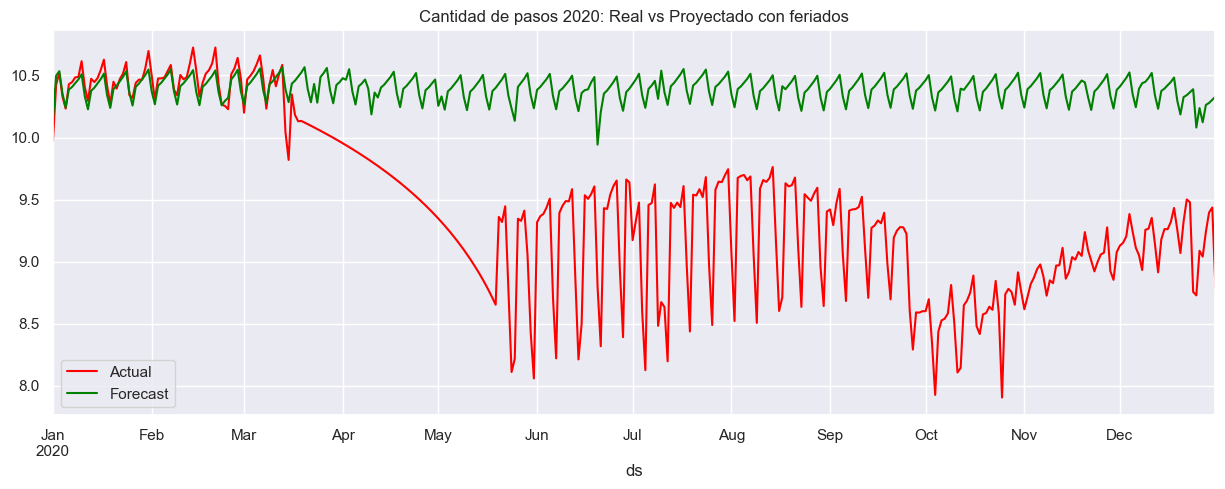

In [85]:
f, ax = plt.subplots(figsize=(14,5))
f.set_figheight(5)
f.set_figwidth(15)
df_test_2020.plot(kind='line',x='ds', y='y', color='red', label='Actual', ax=ax)
X_test_final.plot(kind='line',x='ds',y='yhat', color='green',label='Forecast', ax=ax)
plt.title('Cantidad de pasos 2020: Real vs Proyectado con feriados')
plt.show()

Como hemos anticipado, el modelo muestra un excelente rendimiento hasta marzo, previo a la pandemia, y va decayendo a medida que avanza el año debido a las restricciones de circulacion impuestas por el gobierno nacional.

In [86]:
MAPE_FINAL = mean_absolute_percentage_error(np.exp(df_test_2020['y']),np.exp(X_test_final['yhat']))
print('MAPE FINAL', round(MAPE_FINAL,3))

MAPE FINAL 2.134


In [87]:
rmse_test_final = np.sqrt(mean_squared_error(np.exp(df_test_2020['y']),np.exp(X_test_final['yhat'])))
print("RMSE",round(rmse_test_final,1))

RMSE 19854.0


Era de esperar que las metricas sufran por el impacto que tuvo la pandemia sobre el modelo

## Conclusiones

Durante el trabajo hemos podido construir un modelo optimizado con excelentes resultados en el dataset de prueba. Para construirlo hemos considerado multiples variables como los feriados, la seasonality, los changepoints, como asi tambien accidentes y manifiestaciones.
Lamentablemente la pandemia afecta de manera directa el modelo y lo vuelve poco util. 

Por el otro lado me gustaría incorporar otras variables al modelo, como el tipo de vehiculo, la forma de pago, el sentido para poder hacer un modelo más completo y más preciso.

En el proyecto siguiente intentaré levantar este problema utilizando series de tiempo multivariadas, convirtiendo las variables categoricas en dummies e incorporandolas al modelo para su consideración. Esto va a tener una importante signifcancia a la hora de calcular por ejemplo la facturación esperada por semana o mes, en donde la tarifa esta en funcion del tipo de vehiculo, la forma de pago entre otras variables